In [51]:
#allow autoreload modules at every execution if requested
%load_ext autoreload

import tempfile
import unittest

from pathlib import Path

import numpy as np
import pandas as pd

from cs_parser import CsParser, mappings
from star_parser import StarTabDf, StarParser

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
%autoreload 2
work_folder = Path("/mnt/DATA/andrea/AM_20211112_NeCen_BRCA1AUb/cryolo_train")
test_file = work_folder/"J345_ptcls.cs"
swapxy = True
inverty = True
invertx = False
remove_particles_from_border = False
box_size = 416
mic_size_x = 11520
mic_size_y = 8184
crop_factor = 1 # coordinates are multiplied by this number. 1 => same crop factor on motioncorrection for relion and cryosparc. 2 => uncropped relion, cryosparc crop 2
assert test_file.exists()
destination_file = work_folder/"J345_ptcls.star"
remove_cryosparc_suffix = False # remove _patch_aligned_doseweighted
job_id = "J31"
remove_cryosparc_prefix= True #remove <job_id>/motioncorrected/<micrograph uid>_
replace_micrograph_folder = False

parser = CsParser(test_file)
arr = parser.parse_array()

In [53]:
from pprint import pprint
a = arr.cs_array.copy()
dtypes = a.dtype.fields
problematic = []
clean = []
for index, value in enumerate(list(a[0])):
    if isinstance(value, np.ndarray):
        key = list(a.dtype.fields.keys())[index]
        problematic.append(key)
    else:
        key = list(a.dtype.fields.keys())[index]
        clean.append(key)

In [54]:
mapping_coords = {0:'x', 1:'y', 2:'z'}
mapping_angles = {0:'alpha', 1:'beta', 2:'gamma'}
rascals = a[problematic]
index_column = range(a.shape[0])
reformed = pd.DataFrame(index_column)
# make dummy zero array column
# reformed = np.zeros((rascals[problematic[0]].shape[0], 1))
for key in problematic:
    #if the name of the column is poses, they are angles;
    #otherwise they are shifts
    if 'pose' in key:
        mapping = mapping_angles
    else:
        mapping = mapping_coords
    #split the array into a list of n single columns
    split_arrays = np.hsplit(rascals[key], rascals[key].shape[-1])
    #rename their index
    for index, array in enumerate(split_arrays):
        try:
            new_dtype = (f'{key}_{mapping[index]}')
        except KeyError:
            continue
        reformed[new_dtype] = pd.DataFrame(array)

In [55]:
good = a[clean]
df = pd.DataFrame(good)
new_columns = []
for c in df.columns:
    if c in mappings and mappings[c]:
        new_columns.append(mappings[c])
    else:
        new_columns.append(c)
df.columns = new_columns

In [56]:
frac_coords = df[['FracCoordinateX','FracCoordinateY']]
mic_size = reformed[['location/micrograph_shape_x','location/micrograph_shape_y']]
abs_coords = pd.DataFrame()
#this version of pandas complains about chained assignment even though it does not have a chained assignment
pd.set_option('mode.chained_assignment', None)
if invertx:
    frac_coords.loc[:, 'FracCoordinateX'] = 1 -frac_coords.loc[:,'FracCoordinateX']
if inverty:
    frac_coords.loc[:, 'FracCoordinateY'] = 1- frac_coords.loc[:,'FracCoordinateY']
pd.set_option('mode.chained_assignment', 'warn')
if swapxy:
    abs_coords['CoordinateX'] = pd.DataFrame(frac_coords['FracCoordinateX'] * reformed['location/micrograph_shape_y'])
    abs_coords['CoordinateY'] = pd.DataFrame(frac_coords['FracCoordinateY'] * reformed['location/micrograph_shape_x'])
    abs_coords = abs_coords * crop_factor
    abs_coords = abs_coords.applymap(np.rint).astype(int)
else:
    abs_coords['CoordinateX'] = pd.DataFrame(frac_coords['FracCoordinateX'] * reformed['location/micrograph_shape_x'])
    abs_coords['CoordinateY'] = pd.DataFrame(frac_coords['FracCoordinateY'] * reformed['location/micrograph_shape_y'])
    abs_coords = abs_coords * crop_factor
    abs_coords = abs_coords.applymap(np.rint).astype(int)
abs_coords


,CoordinateX,CoordinateY
0,914,380
1,2347,501
2,4248,2204
3,4454,2682
4,4318,1830
...,...,...
106151,1457,3293
106152,3930,3618
106153,1714,3653
106154,3414,3809


In [57]:
df[abs_coords.columns] = abs_coords
for column in ['ImageName', 'MicrographName']:
    try:
        df[column] = df[column].str.decode('utf-8')
    except KeyError:
        pass

In [58]:
df = df.astype(str)
starparser = StarParser(destination_file, create=True)
data = starparser.read_df(df)
data['data_'].to_df()

,uid,ImageName,blob/idx,PixelSize,blob/sign,blob/import_sig,MicrographUid,OpticsGroup,MicrographName,FracCoordinateX,...,alignments3D/alpha,alignments3D/alpha_min,alignments3D/weight,alignments3D/pose_ess,alignments3D/shift_ess,alignments3D/class_posterior,alignments3D/class,alignments3D/class_ess,CoordinateX,CoordinateY
0,10641606438417909229,J345/extract/005836748375176244967_FoilHole_12...,0,3.344,-1.0,0,5836748375176244967,0,J31/motioncorrected/005836748375176244967_Foil...,0.15876248,...,1.0474291,0.0,0.0,0.0,0.0,0.9995119,1,1.0009768,914,380
1,7636242831103518619,J345/extract/005836748375176244967_FoilHole_12...,1,3.344,-1.0,0,5836748375176244967,0,J31/motioncorrected/005836748375176244967_Foil...,0.4075472,...,1.1934142,0.0,0.0,0.0,0.0,1.0,1,1.0,2347,501
2,15288982687142075776,J345/extract/005836748375176244967_FoilHole_12...,2,3.344,-1.0,0,5836748375176244967,0,J31/motioncorrected/005836748375176244967_Foil...,0.7375819,...,1.3133398,0.0,0.0,0.0,0.0,1.0,1,1.0,4248,2204
3,3176278967588816736,J345/extract/005836748375176244967_FoilHole_12...,3,3.344,-1.0,0,5836748375176244967,0,J31/motioncorrected/005836748375176244967_Foil...,0.7732015,...,1.2287867,0.0,0.0,0.0,0.0,1.0,1,1.0,4454,2682
4,16502081062352082656,J345/extract/005836748375176244967_FoilHole_12...,4,3.344,-1.0,0,5836748375176244967,0,J31/motioncorrected/005836748375176244967_Foil...,0.74965656,...,1.2326466,0.0,0.0,0.0,0.0,1.0,0,1.0,4318,1830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106151,5005155810161403635,J345/extract/000376184663170499449_FoilHole_12...,17,3.344,-1.0,0,376184663170499449,0,J31/motioncorrected/000376184663170499449_Foil...,0.2529031,...,1.0,0.99316466,0.0,0.0,0.0,1.0,0,1.0,1457,3293
106152,12259800455844317240,J345/extract/000376184663170499449_FoilHole_12...,18,3.344,-1.0,0,376184663170499449,0,J31/motioncorrected/000376184663170499449_Foil...,0.68230593,...,1.0,1.0152254,0.0,0.0,0.0,1.0,0,1.0,3930,3618
106153,2187031090802756429,J345/extract/000376184663170499449_FoilHole_12...,19,3.344,-1.0,0,376184663170499449,0,J31/motioncorrected/000376184663170499449_Foil...,0.29751247,...,1.0,1.0085952,0.0,0.0,0.0,1.0,0,1.0,1714,3653
106154,15951847050372647484,J345/extract/000376184663170499449_FoilHole_12...,20,3.344,-1.0,0,376184663170499449,0,J31/motioncorrected/000376184663170499449_Foil...,0.59273386,...,1.0,1.0729402,0.0,0.0,0.0,1.0,0,1.0,3414,3809


In [59]:
tab = data['data_']
tab.keep_only_columns(['MicrographName','CoordinateX','CoordinateY'], store=True)

,MicrographName,CoordinateX,CoordinateY
0,J31/motioncorrected/005836748375176244967_Foil...,914,380
1,J31/motioncorrected/005836748375176244967_Foil...,2347,501
2,J31/motioncorrected/005836748375176244967_Foil...,4248,2204
3,J31/motioncorrected/005836748375176244967_Foil...,4454,2682
4,J31/motioncorrected/005836748375176244967_Foil...,4318,1830
...,...,...,...
106151,J31/motioncorrected/000376184663170499449_Foil...,1457,3293
106152,J31/motioncorrected/000376184663170499449_Foil...,3930,3618
106153,J31/motioncorrected/000376184663170499449_Foil...,1714,3653
106154,J31/motioncorrected/000376184663170499449_Foil...,3414,3809


<AxesSubplot:>

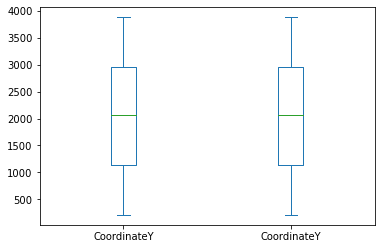

In [60]:
tab.to_df()[['CoordinateY', 'CoordinateY']].astype(int).plot(kind='box')

In [61]:
if remove_cryosparc_prefix:
    tab.trim_column_values('MicrographName', len("J31/motioncorrected/"), store=True)
    for l in tab.to_df()['MicrographName']:
        assert l.startswith('FoilHole')
tab.to_df()

AssertionError: 

In [ ]:
if remove_cryosparc_suffix:
    tab.remove_string_from_column_name('_patch_aligned_doseweighted', 'MicrographName', store=True)["MicrographName"][0]
tab.to_df()

,MicrographName,CoordinateX,CoordinateY
0,J31/motioncorrected/005836748375176244967_Foil...,914,380
1,J31/motioncorrected/005836748375176244967_Foil...,2347,501
2,J31/motioncorrected/005836748375176244967_Foil...,4248,2204
3,J31/motioncorrected/005836748375176244967_Foil...,4454,2682
4,J31/motioncorrected/005836748375176244967_Foil...,4318,1830
...,...,...,...
106151,J31/motioncorrected/000376184663170499449_Foil...,1457,3293
106152,J31/motioncorrected/000376184663170499449_Foil...,3930,3618
106153,J31/motioncorrected/000376184663170499449_Foil...,1714,3653
106154,J31/motioncorrected/000376184663170499449_Foil...,3414,3809


In [ ]:
#Won't work for splitting files
if replace_micrograph_folder:
    old_folder = 'J31/motioncorrected/'
    new_folder = 'micrographs/'
    tab.replace_string_in_column(old_folder, new_folder, 'MicrographName', store=True)
tab.to_df()

,MicrographName,CoordinateX,CoordinateY
0,micrographs/005836748375176244967_FoilHole_123...,914,380
1,micrographs/005836748375176244967_FoilHole_123...,2347,501
2,micrographs/005836748375176244967_FoilHole_123...,4248,2204
3,micrographs/005836748375176244967_FoilHole_123...,4454,2682
4,micrographs/005836748375176244967_FoilHole_123...,4318,1830
...,...,...,...
106151,micrographs/000376184663170499449_FoilHole_123...,1457,3293
106152,micrographs/000376184663170499449_FoilHole_123...,3930,3618
106153,micrographs/000376184663170499449_FoilHole_123...,1714,3653
106154,micrographs/000376184663170499449_FoilHole_123...,3414,3809


In [ ]:
tab.df = tab.to_df().astype(str)
starparser.write_out(to_file=True)

Data written to /mnt/DATA/andrea/AM_20211112_NeCen_BRCA1AUb/cryolo_train/J345_ptcls.star


In [62]:
split = tab.to_df().groupby('MicrographName')
split_dir = work_folder/'train_annotations'
if not split_dir.exists():
    split_dir.mkdir()
for fname, data in split:
    x = StarTabDf(data)
    fname = fname.replace('.mrc','.star')
    with open(split_dir/fname, 'w') as f:
        f.write(x.to_star())

In [84]:
#clean a particle.cs so that it does not stump csparc2star anymore
clean=False
if clean:
    new_fields = []
    new_keys = []

    for key, value in arr.cs_array.dtype.fields.items():
        if not key.startswith('alignments'):
            new_fields.append({key:value})
            new_keys.append(key)
    with open(work_folder/'temp.cs' , 'wb') as f:
        np.save(f, arr.cs_array[new_keys])
    